In [ ]:
import os
import numpy as np
import torch
import pickle
import requests

In [ ]:
!git clone https://github.com/BlairLeng/VoiceForge.git

Cloning into 'VoiceForge'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 3), reused 33 (delta 3), pack-reused 0
Receiving objects: 100% (37/37), 324.89 KiB | 12.50 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import pickle


import requests
from VoiceForge.audio_feature_ext.modules.ecapa_tdnn import EcapaTdnn, SpeakerIdetification
from VoiceForge.audio_feature_ext.data_utils.reader import load_audio, CustomDataset

class AudioFeatureExtraction:
    def __init__(self,model_director='./audio_feature_ext/models', feature_method='melspectrogram' ):
        self.use_model = ''
        self.model_director = model_director
        self.feature_method = feature_method
        self.model = None
        self.device = None
        self.load_model()

    def init_models(self,path):
        model_urls = ['https://huggingface.co/scixing/voicemodel/resolve/main/model.pth',
                      'https://huggingface.co/scixing/voicemodel/resolve/main/model.state',
                      'https://huggingface.co/scixing/voicemodel/resolve/main/optimizer.pth']
        listdir = os.listdir(path)
        for url in model_urls:
            filename = url.split('/')[-1]
            if filename in listdir:
                continue
            r = requests.get(url, allow_redirects=True)
            print(f'downloading model pth {filename}')
            open(f'{path}/{filename}', 'wb').write(r.content)
            print(f'{filename} success download')

    def load_model(self):
        dataset = CustomDataset(data_list_path=None, feature_method=self.feature_method)
        ecapa_tdnn = EcapaTdnn(input_size=dataset.input_size)
        self.model = SpeakerIdetification(backbone=ecapa_tdnn)
        self.device = torch.device("cuda")
        self.model.to(self.device)

        if not os.path.exists(self.model_director):
            os.makedirs(self.model_director)
        model_files = ['model.pth', 'model.state', 'optimizer.pth']
        for file in model_files:
            if not os.path.exists(f'{self.model_director}/{file}'):
                self.init_models(self.model_director)

        # 加载模型
        model_path = os.path.join(self.model_director, 'model.pth')
        model_dict = self.model.state_dict()
        param_state_dict = torch.load(model_path)
        for name, weight in model_dict.items():
            if name in param_state_dict.keys():
                if list(weight.shape) != list(param_state_dict[name].shape):
                    param_state_dict.pop(name, None)
        self.model.load_state_dict(param_state_dict, strict=False)
        print(f"成功加载模型参数和优化方法参数：{model_path}")
        self.model.eval()

    def infer(self, audio_path, duration):
        data = load_audio(audio_path, mode='infer', feature_method=self.feature_method,
                          chunk_duration=duration)
        data = data[np.newaxis, :]
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        feature = self.model.backbone(data)
        return feature.data.cpu().numpy()

In [ ]:
AFE = AudioFeatureExtraction()

成功加载模型参数和优化方法参数：./audio_feature_ext/models/model.pth


In [ ]:
import wave
import contextlib

In [ ]:
import os
import fnmatch

# 定义文件夹路径
folder_path = '/content/drive/MyDrive/GPTData/Haruhi_audio'

audio_path_list = []
# 使用os模块列出文件夹中所有的文件和子文件夹
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # 使用fnmatch模块匹配以.wav结尾的文件
        if fnmatch.fnmatch(file, '*.wav'):
            # 打印或处理符合条件的文件
            audio_path_list.append(os.path.join(root, file))
print(len(audio_path_list))

10695


In [ ]:
audio_feature_list = []
counter = 1
for i in audio_path_list:
    file_path = i
    print(counter)
    with contextlib.closing(wave.open(file_path, 'rb')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    audio_feature_list.append(AFE.infer(file_path, duration)[0])
    counter += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=400 is too large for input signal of length=0
  warnings.warn(


Streaming output truncated to the last 5000 lines.
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
4

In [50]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib


def visulization_np(inputs: np.ndarray):
    raws, cols = inputs.shape
    if raws == 192:
        inputs = inputs.transpose()
        raws, cols = inputs.shape
    # print(inputs.shape)

    # 进行 tSNE 计算
    tsne = TSNE(n_components=2, random_state=0)
    reduced_data = tsne.fit_transform(inputs)
    # print(reduced_data.shape)

    # 方便可视化不同的颜色
    labels = np.random.randint(0, 1, raws)

    # 可视化
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='jet', s=50)
    plt.colorbar(scatter)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('2D t-SNE visualization of the data')
    plt.show()

In [51]:
audio_feature_list = np.array(audio_feature_list)

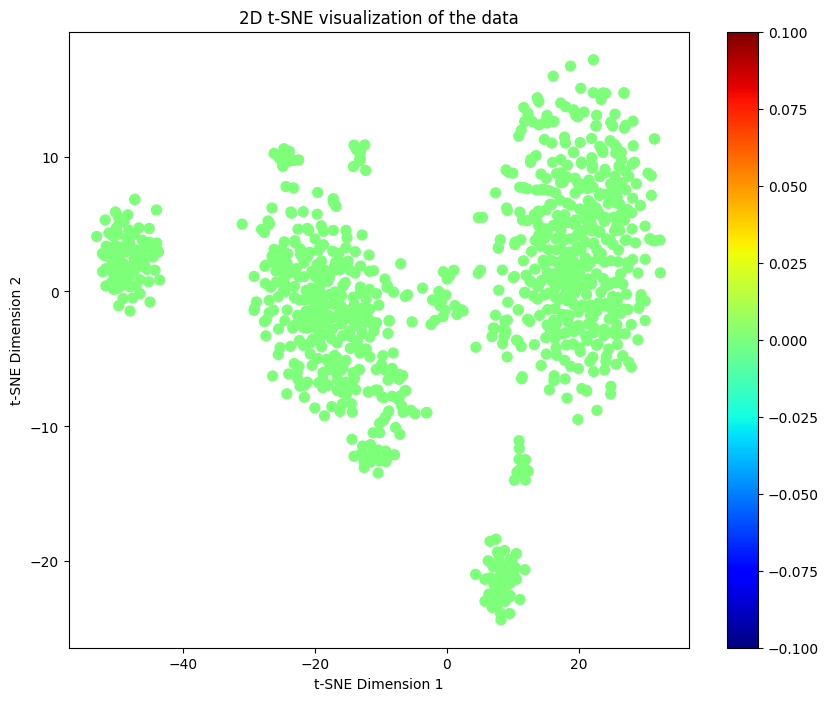

In [52]:
visulization_np(audio_feature_list)